# k-Means Clustering for numerical features

In [166]:
import pandas as pd
import networkx as nx
from sklearn.cluster import KMeans

In [167]:
df_posts = pd.read_json('../data/dataset.json')

In [168]:
df_posts['timestamp'] = pd.to_datetime(df_posts['timestamp'])

## Extract numeric features

### Temporal features

Number of posts over time

In [169]:
df_posts['posts_per_user'] = df_posts.groupby('user')['timestamp'].count()

Time between consecutive posts

In [170]:
# Calculate the time difference between posts
df_posts['time_diff'] = df_posts.groupby('user')['timestamp'].diff()

# Convert time_diff to timedelta
df_posts['time_diff'] = pd.to_timedelta(df_posts['time_diff'], errors='coerce')

# Replace NaT with the median time difference
df_posts['time_diff'] = df_posts['time_diff'].fillna(df_posts['time_diff'].median())

In [171]:
# Convert time_diff to seconds
df_posts['time_diff_seconds'] = df_posts['time_diff'].dt.total_seconds()

# Drop the time_diff column
df_posts = df_posts.drop(columns=['time_diff'])

### Text-based features

Tweet length

In [172]:
df_posts['text_length'] = df_posts['text'].apply(len)

Word count

In [173]:
df_posts['word_count'] = df_posts['text'].apply(lambda x: len(x.split()))

Sentiment Analysis score

In [174]:
sentiment_df = pd.read_csv('../output/sentiment.csv')

sentiment_subset = sentiment_df[['text_id', 'sentiment_score']]

df_posts = pd.merge(df_posts, sentiment_subset, on='text_id', how='left')

Hashtag count

In [175]:
df_posts['hashtag_count'] = df_posts['text'].str.count('#')

Topics from BERTopic

In [176]:
topics_df = pd.read_csv('../output/posts_with_topics.csv')

# Select only 'text_id' and 'topic_label' from topics_df
topics_subset = topics_df[['text_id', 'topic', 'topic_label']]

# Merge df_posts with the topics_subset on 'text_id'
df_posts = pd.merge(df_posts, topics_subset, on='text_id', how='left')

### Network Features

Follower count

In [177]:
# Load data
edges = pd.read_csv('../data/graph.csv')

# Create a graph
G = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr='weight')

# Calculate degrees
degrees = dict(G.degree())
degree_df = pd.DataFrame(degrees.items(), columns=['user_id', 'degree'])

Clustering Coefficient (how connected a user's neighbors are in the network)

In [178]:
clustering_coeff = nx.clustering(G)
clustering_df = pd.DataFrame(clustering_coeff.items(), columns=['user_id', 'clustering_coeff'])

Influence Score

In [179]:
pagerank = nx.pagerank(G)
pagerank_df = pd.DataFrame(pagerank.items(), columns=['user_id', 'pagerank'])

Betweenness Centrality

### Aggregate Features per User

Average Post Sentiment Per User

In [180]:
df_posts['avg_sentiment'] = df_posts.groupby('user_id')['sentiment_score'].transform('mean')

Variability in Posting Times

In [181]:
time_std = df_posts.groupby('user_id')['timestamp'].std().reset_index(name='time_std')

Merge Dataframe

In [182]:
# Merge the other dataframes onto df_posts
df_posts = df_posts.merge(degree_df, on="user_id", how="left")
df_posts = df_posts.merge(clustering_df, on="user_id", how="left")
df_posts = df_posts.merge(pagerank_df, on="user_id", how="left")

print(df_posts)

                timestamp                                               text  \
0     2024-10-31 00:00:00  Running a business means juggling countless ad...   
1     2024-10-31 00:00:00  Liz Truss is walking in the lingering shadow o...   
2     2024-10-31 00:00:00  The UK is bracing for war as government buildi...   
3     2024-10-31 00:00:00  Marrying a second or third cousin once removed...   
4     2024-10-31 00:00:00  It's truly disgraceful how the Indian National...   
...                   ...                                                ...   
70255 2024-10-31 23:59:52  @bakerjulie: "Saranghae, I’m your resident K-P...   
70256 2024-10-31 23:59:52  Soaring to new heights with @sweeneyanthony! T...   
70257 2024-10-31 23:59:54  Hey @james20 @paul47, did you see the latest f...   
70258 2024-10-31 23:59:58  Check out the fundraiser exhibition by @joanna...   
70259 2024-10-31 23:59:59  The appointment of Rees Mogg as business secre...   

          text_id              user    

In [183]:
df_posts = df_posts[df_posts['topic_label'] != 'Other']

# Sentiment by Topic

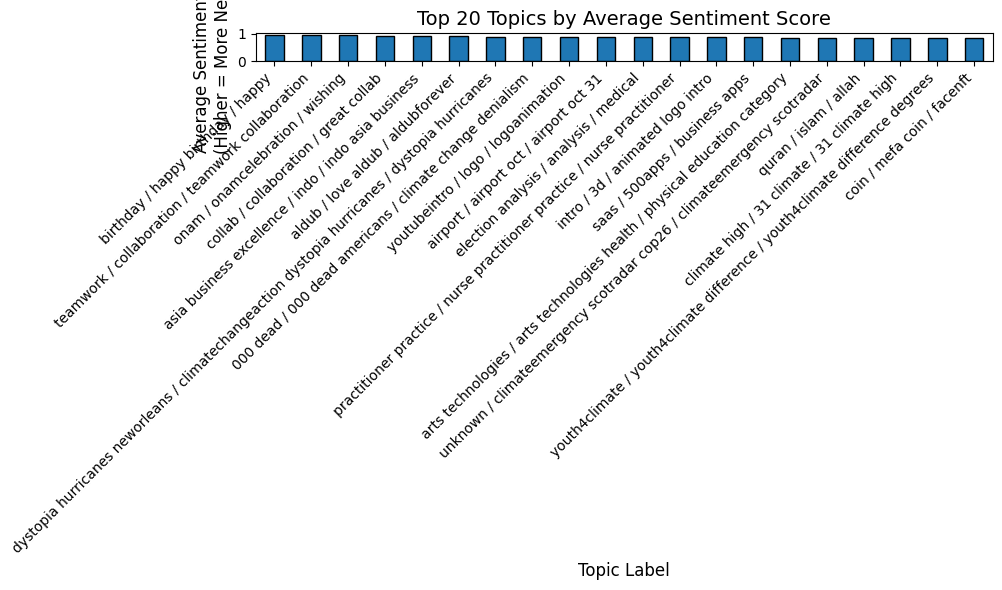

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by topic_label and calculate the mean sentiment score
topic_sentiment = (
    df_posts.groupby('topic_label')['sentiment_score']
    .mean()
    .sort_values(ascending=False)  # Sort in descending order
)

# Select only the top 20 topics
top_20_topics = topic_sentiment.head(20)

# Plot the top 20 topics
plt.figure(figsize=(10, 6))
top_20_topics.plot(kind='bar', edgecolor='black')  # Added a color for better visualization
plt.title('Top 20 Topics by Average Sentiment Score', fontsize=14)
plt.xlabel('Topic Label', fontsize=12)
plt.ylabel('Average Sentiment Score\n(Higher = More Negative)', fontsize=12)  # Added a line break
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

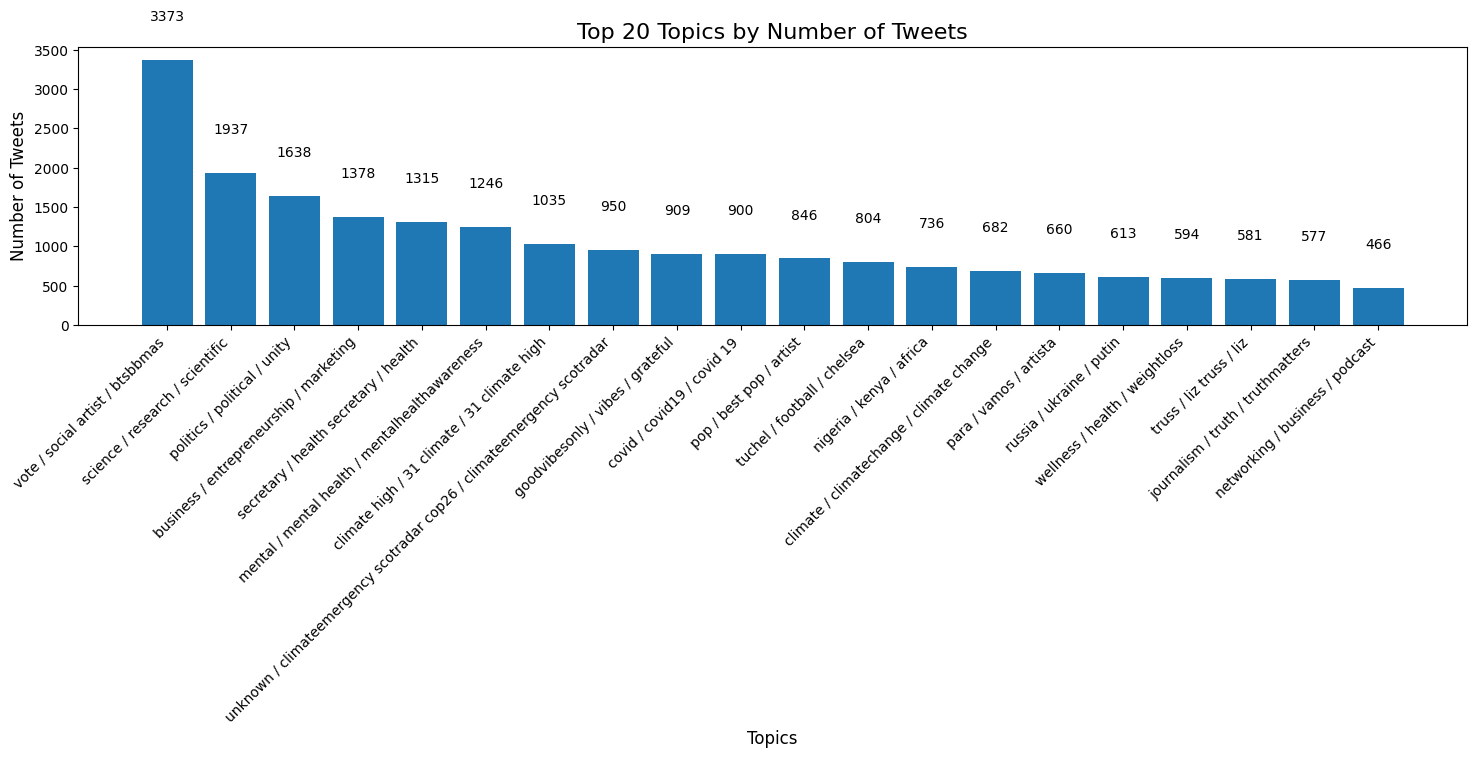

In [185]:
import matplotlib.pyplot as plt

topic_counts = df_posts.groupby('topic_label').size().reset_index(name='tweet_count')
top_topics = topic_counts.sort_values(by='tweet_count', ascending=False).head(20)

plt.figure(figsize=(15, 8))  # Increase figure size
bars = plt.bar(top_topics['topic_label'], top_topics['tweet_count'])

plt.title('Top 20 Topics by Number of Tweets', fontsize=16)
plt.xlabel('Topics', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,  # Offset height slightly for visibility
             str(bar.get_height()), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [186]:
from sklearn.preprocessing import StandardScaler

# Select features for normalization
features_to_normalize = [
    "posts_per_user", 
    "time_diff_seconds", "text_length",
    "word_count", 
    "sentiment_score", "hashtag_count", 
    "degree", 
    "clustering_coeff", 
    "pagerank",
]

# Replace NaN values with 0
df_posts[features_to_normalize] = df_posts[features_to_normalize].fillna(0)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected features
normalized_features = scaler.fit_transform(df_posts[features_to_normalize])

# Convert back to a DataFrame
normalized_df = pd.DataFrame(normalized_features, columns=features_to_normalize)

# Add normalized columns back to the original DataFrame (optional)
df_posts_normalized = pd.concat([df_posts, normalized_df.add_suffix("_normalized")], axis=1)

# Check the resulting DataFrame
print(df_posts_normalized.head())

   timestamp                                               text       text_id  \
0 2024-10-31  Running a business means juggling countless ad...  2.018570e+09   
1 2024-10-31  Liz Truss is walking in the lingering shadow o...  2.092718e+09   
2 2024-10-31  The UK is bracing for war as government buildi...  2.059143e+09   
4 2024-10-31  It's truly disgraceful how the Indian National...  2.001239e+09   
5 2024-10-31  The schools are teaching kids about climate ch...  2.068121e+09   

               user       user_id  posts_per_user  time_diff_seconds  \
0     danielwoodard  1.077866e+09             0.0             2733.0   
1  nelsonjacqueline  1.089670e+09             0.0             2733.0   
2           ihooper  1.007479e+09             0.0             2733.0   
4         michael51  1.021456e+09             0.0             2733.0   
5           ihooper  1.007479e+09             0.0                0.0   

   text_length  word_count  sentiment_score  ...  pagerank  \
0        225.0    

In [189]:
# Select normalized features for clustering
normalized_features = [col for col in df_posts_normalized.columns if col.endswith("_normalized")]
X = df_posts_normalized[normalized_features]

In [190]:
# Fill NaNs with 0
X = X.fillna(0)

# Or fill with the column mean
X = X.fillna(X.mean())

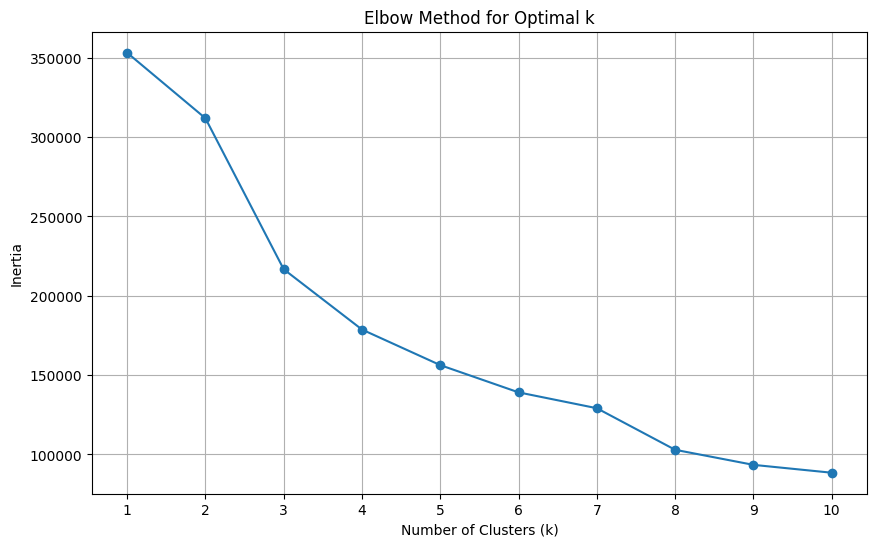

In [191]:
inertia = []
k_values = range(1, 11)  # Try k values from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)
plt.show()